# Tour du Mont-Blanc trekking

Facing new challenges is always a good thing. And they can be of any type.

This summer, I decided to go hiking around the Mont-Blanc (highest montain in Europe). Short context:

- We hiked 9 days
- We were a group of 3 people
- We were carrying a tent and used it every night
- We did approximately 160 km in total

I had different goals for this trekking:

1. For personal reasons, this is something I've wanted to do for about a year
2. Track GPS data and write some kind of report with numbers and graphs
3. Face a new challenge to push my physical limits and motivation further

While I was preparing the Tour du Mont-Blanc (TMB), it was quite difficult to find good information about the different days. Sure there are **plenty** of blog posts from other trekkers, books and guides with useful advice. But what I really wanted was a good online resource showing kilometers, elevation and times for all the different parts of the track. And I couln't find any!

The purpose of this notebook is to provide this "stats oriented guide", and show how convenient it can be to mix programming and story telling.

## Gear

The GPS data was recorded with a standard Android phone (Nexus 5).

Just before starting the walk, we would just initiate the recording and let the device do its job. Sometimes (although not systemactically), I would place a mark for longer breaks like (lunch).

Looking at the graphs below, you will notice disparities in the data, due to the quality of the sampling. They can be quite annoying, especially when computing summary statistics related to the elevation. But data analysis is also about this: dealing with data that is not necessary clean and well formated.

And that's it for the gear. Of course it is useful to have a spare battery to recharge the phone.

## Visualizing the data

There are several websites online that makes it possible to visualize GPS data. The only thing to do is to upload a GPX file.

A good one is [mapexplorer.com](http://maplorer.com/view_gpx.html). Upload a GPX file to visualize both the trace map and the elevation graph. Quite useful for single tracks, but not practical to in this case when the goal is to do some story telling for a multi-day trip.

With the Jupyter Notebook, it becomes very easy to write text and show photos while plotting data. Super convenient to tell a story!

## Setup

Let's define some tools and libraries needed to create the statistics and graphs.

In [21]:
import datetime
import folium
import gpxpy
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import qgrid
import srtm
from collections import defaultdict
from IPython.display import display
from pytz import timezone
from statistics import mean

%matplotlib inline
plt.rcdefaults()
sns.set_style('darkgrid')
sns.set_palette('deep', desat=.6)
sns.set_context(rc={"figure.figsize": (16, 9)})

france = timezone('Europe/Paris')

qgrid.set_defaults(remote_js=None)

`folium` will be used to display the maps, and `gpxpy` to load and manipulate gpx data.

`srtm` will help fix the elevation data recorded by the Android device. The raw is indeed not that good and shows lots of jumps in the elevation.

In [22]:
DATA_FOLDER = 'gps_data/'
data_files = [os.path.join(DATA_FOLDER, f) for f in os.listdir(DATA_FOLDER)]

# sort by day
data_files.sort()

# retrieve the elevation data to fix the raw (recorded) elevation
elevation_data = srtm.get_data()

Now, let's build a mini framework that will be reused for each day. Doing so, we can minimize the number of lines of code and focus on the story telling.

To make it simpler, let's load all the data at once.

In [23]:
day_points = []
stats = defaultdict(list)

for file in data_files:
    with open(file, 'r') as f:
        gpx = gpxpy.parse(f)
        
    elevation_data.add_elevations(gpx, smooth=True)
        
    points = gpx.get_points_data()
    day_points.append({
        'points': points,
        'waypoints': gpx.waypoints
    })
    
    lowest, highest = gpx.get_elevation_extremes()
    uphill, downhill = gpx.get_uphill_downhill()
    stats['Date'].append(gpx.get_time_bounds().start_time)
    stats['Distance'].append(points[-1].distance_from_start / 1000)
    stats['Duration'].append(str(datetime.timedelta(seconds=gpx.get_duration())))
    stats['Lowest'].append(int(lowest))
    stats['Highest'].append(int(highest))
    stats['Uphill'].append(int(uphill))
    stats['Downhill'].append(int(downhill))
    
df = pd.DataFrame(
        stats,
        columns=['Date', 'Distance', 'Duration',
                 'Lowest', 'Highest', 'Uphill', 'Downhill'],
    )

# reindex by date
df = df.set_index(['Date'])

# custom formatter
df['Distance'] = df['Distance'].map('{:.2f} km'.format)
df['Lowest'] = df['Lowest'].map('{} m'.format)
df['Highest'] = df['Highest'].map('{} m'.format)
df['Uphill'] = df['Uphill'].map('{} m'.format)
df['Downhill'] = df['Downhill'].map('{} m'.format)

Then, given a set of points, plot them on a map.

In [24]:
def plot_track(points, waypoints):
    points = [p.point for p in points]
    mean_lat = mean(p.latitude for p in points)
    mean_lng = mean(p.longitude for p in points)
    
    # create the map
    m = folium.Map(location=[mean_lat, mean_lng], zoom_start=13)
    
    pts = [tuple([p.latitude, p.longitude]) for p in points]
    folium.PolyLine(pts, color='red', weight=2.5, opacity=1).add_to(m)
    
    # sometimes, there are some markers to indicate breaks, lunch or rest
    for p in waypoints:
        marker = folium.Marker(tuple([p.latitude, p.longitude]), popup=p.name.strip())
        marker.add_to(m)
    
    display(m)

Plot all the days

In [38]:
def plot_all_tracks():
    points = [pt for pts in day_points for pt in pts['points']]
    plot_track(points, [])

Given a set of points, plot the elevation over the distance.

In [25]:
def plot_elevation(points, waypoints):
    px = [p.distance_from_start / 1000 for p in points]
    py = [p.point.elevation for p in points]
    plt.plot(px, py)
    plt.xlabel('Distance (km)')
    plt.ylabel('Elevation (m)')
    plt.show()

Given a day, show its statistics.

In [26]:
def plot_day(day):
    points = day_points[day - 1]['points']
    wps = day_points[day - 1]['waypoints']
    display(qgrid.show_grid(df[day-1:day]))
    plot_track(points, wps)
    plot_elevation(points, wps)

Once the tools are setup, it is time for the trip!

## Day 1: Les Houches - Chalets de Miage

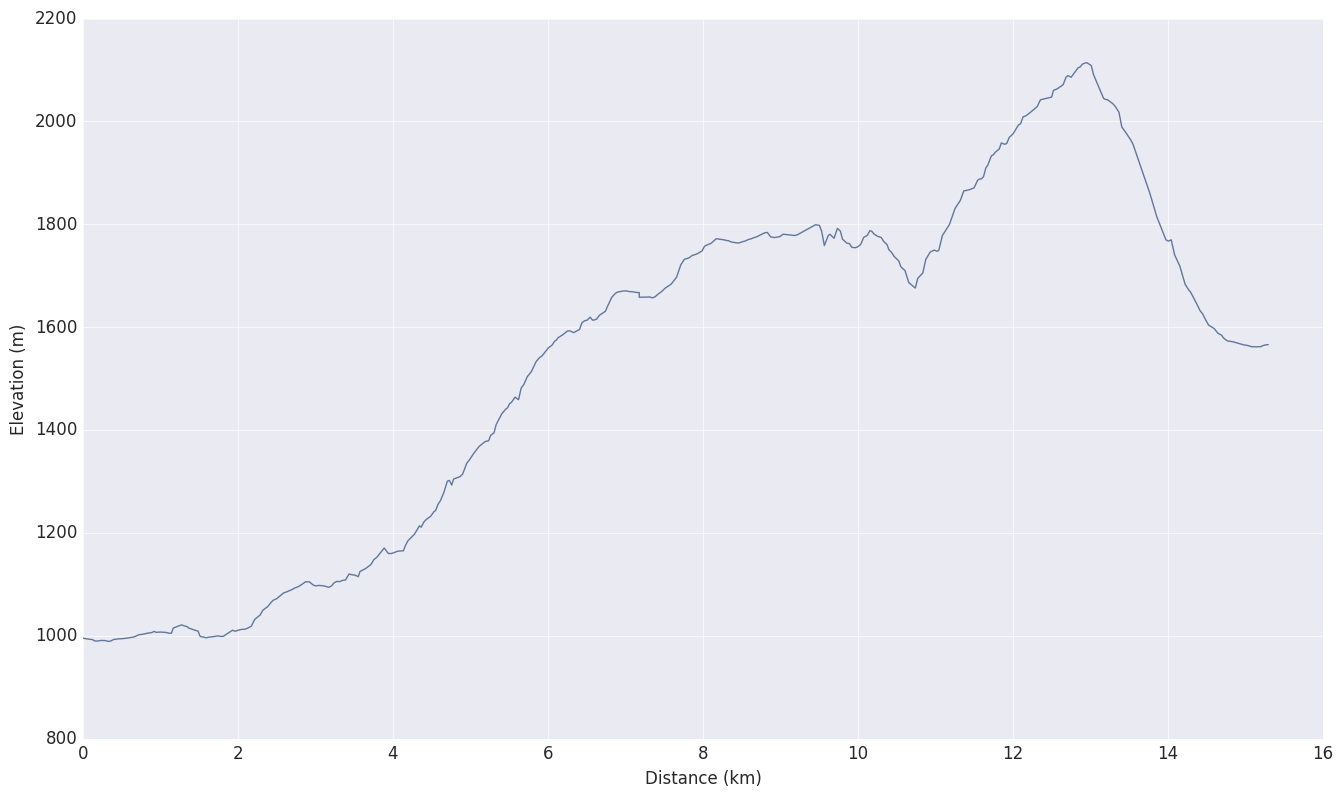

In [27]:
plot_day(1)

Quite challenging for a first day!

We started with the rain. Damn, that wasn't really convincing. Good for a first motivation test though. Fortunately the weather became way better a few hours later.

Pretty steep start, going huphill until Col de la Voza. We continued on our way up to reach a highest of 2162 m. Followed by a quite abrupt way down to Chalets de Miage, that we could see from Col de Tricot. Poor knees!

## Day 2: Chalets de Miage - Refuge du Col de la Croix du Bonhomme

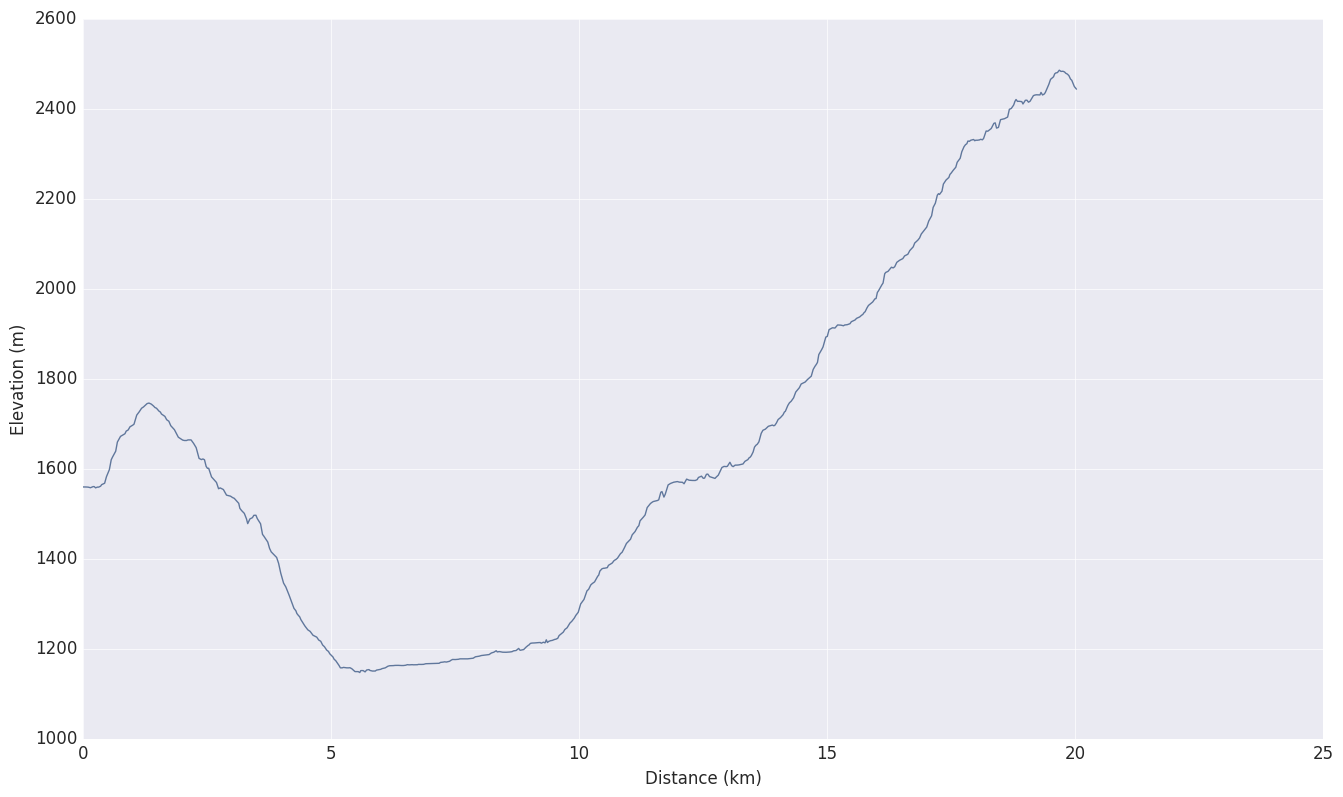

In [28]:
plot_day(2)

The second day was probably one of the most difficult of the entire trip:

- It was the second day only, still a long way to go until the end
- First pain in the back and on the shoulders due to the heavy backpacks (even though it was quite expected)
- Long distance and high elevation difference

In the morning, we passed though the small village of Les Contamines-Montjoie. Perfect timing to pick up some fresh fruits at the market.

It was also a good occasion to have a look at the elegant Notre Dame de la Gorge.

Arriving at Refuge du Col de la Croix du Bonhomme (loooooong name), we were pleased to find a herd of mountain goat the neighbor creast. Since it was the end of the day, it gave a nice silhouette effect.

## Day 3: Refuge du Col de la Croix du Bonhomme - Lac du Miage

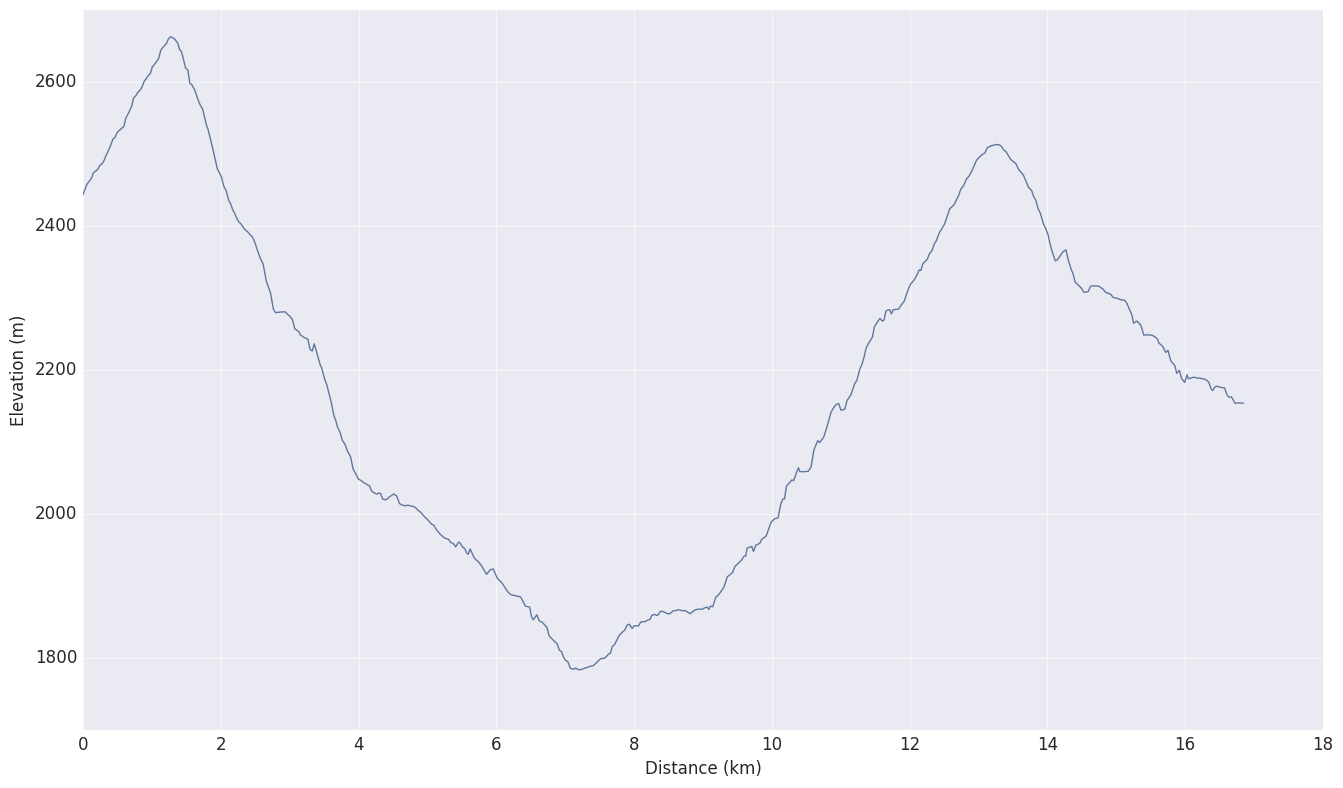

In [29]:
plot_day(3)

Day 3 was another long day.

This day was full of surprises and different landscapes. The valley from Col de la Seigne to Lac du Miage was quite daunting: such a bit opening in the middle of the mountains.

At first, we thought we could find a nice spot for the night around the Lac de Combal. It turns out it's more a swamp than a lake!

We pushed the hike a little bit further to Lac du Miage to find a very sweet camping spot. We could also take a (refreshing) bath in this lake, quick but very appreciated.

## Day 4: Lac du Miage - Camping "La Sorgente" (Courmayeur)

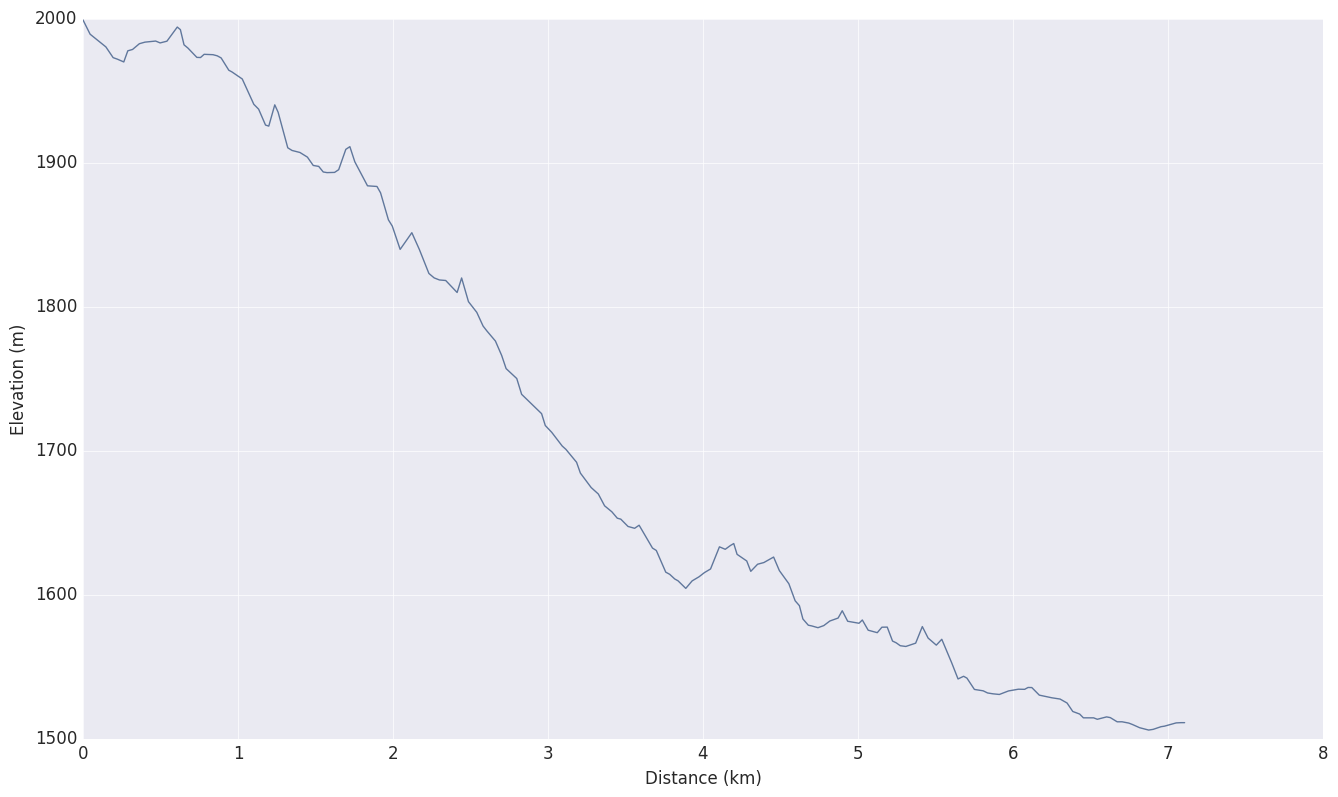

In [30]:
plot_day(4)

A day with less than 100 m uphill. How unusual this is!

Following the two previous demanding days, we decided it would be wise to take it easy for day 4.

We first hiked down to a proper camp site, Camping "La Sorgente". Comfort and shower helped us to recharge batteries. We then decided to walk down to Courmayeur and visit the city. At the end of the day, we went back to the camp site by bus before the storm.

## Day 5: Camping "La Sorgente" - Chalet Val Ferret

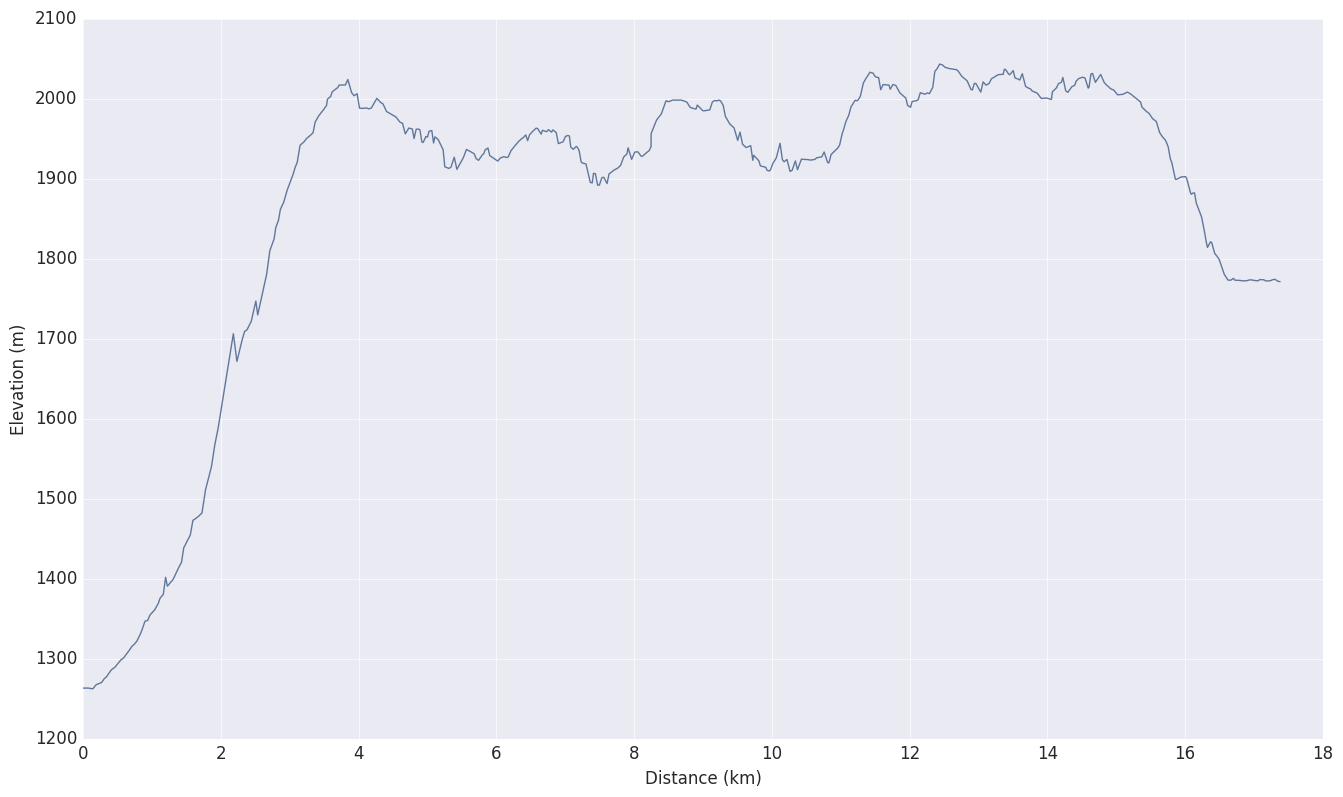

In [31]:
plot_day(5)

Our first rainy day :(

We knew we would have at least a day of rain during the entire trip. Even though the elevation chart looks quite flat, the rain made the paths very slippery. Full focus required, especially for the way down at the end of the day.

We stopped next to the Chalet Val Ferret, and spend the evening eating warm food and play cards. Our first goal was to reach the Refuge Elena, but in retrospect it was so much wiser to stop a bit before and spend a correct night.

## Day 6: Chalet Val Ferret - Champex-Lac

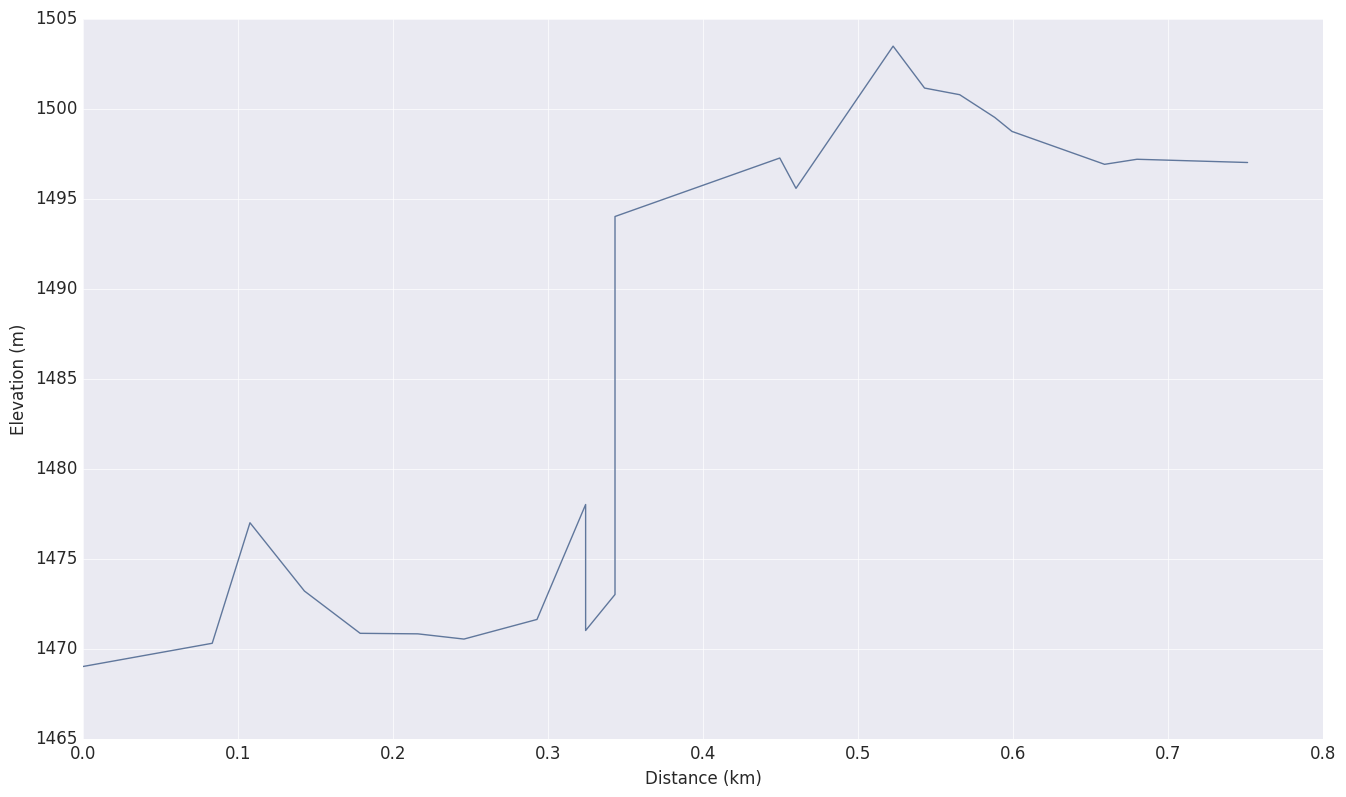

In [32]:
plot_day(6)

Another day, another border cross.

Time to go to Italy. We first passed next to Refuge Elena, then the Grand Col Ferret. It was super windy up there.

We made our way down to La Fleury and took the bus directly to Champex-Lac. 

Why the bus? This is something we had planned beforehand to be able to do the tour in 9 days. It saved us many kilomters and time. Plus, this portion of the trip looked a bit less interesting than the rest (as mentioned in other blog posts).

## Day 7: Champex-Lac - Col de la Forclaz

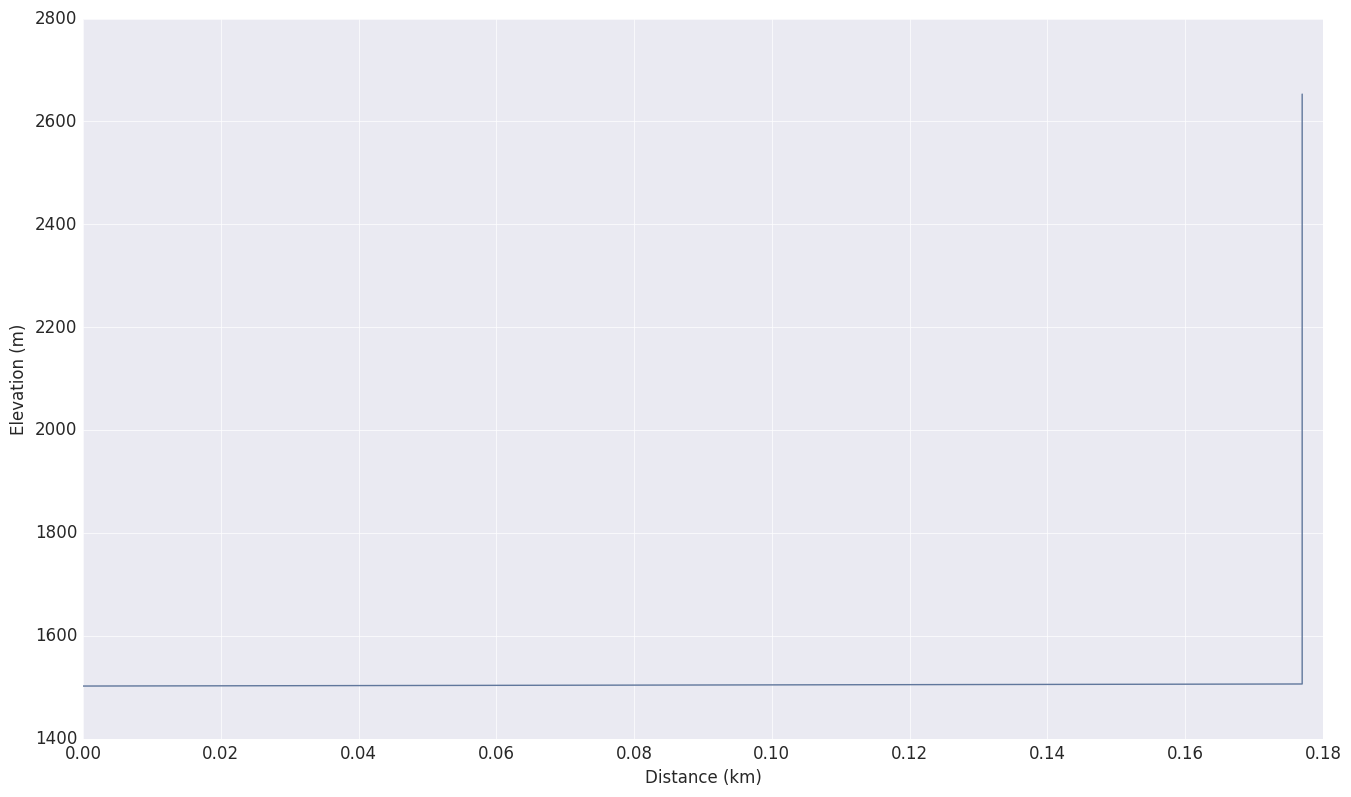

In [33]:
plot_day(7)

Starting from Champex-Lac, we had the choice to either go with the normal route, or go with a variant.

We went for the variant (more challenge, more fun!), and were not disappointed at all.

This brought us to Fenêtre d'Arpette, one of the highest point of the Tour du Mont Blanc. The weather was beautiful and the view from the top amazing. Totally worth it.

The way down to Col de la Forclaz was however rather long and repetitive. Bad for the knees once again!

## Day 8: Col de la Forclaz - Argentiere

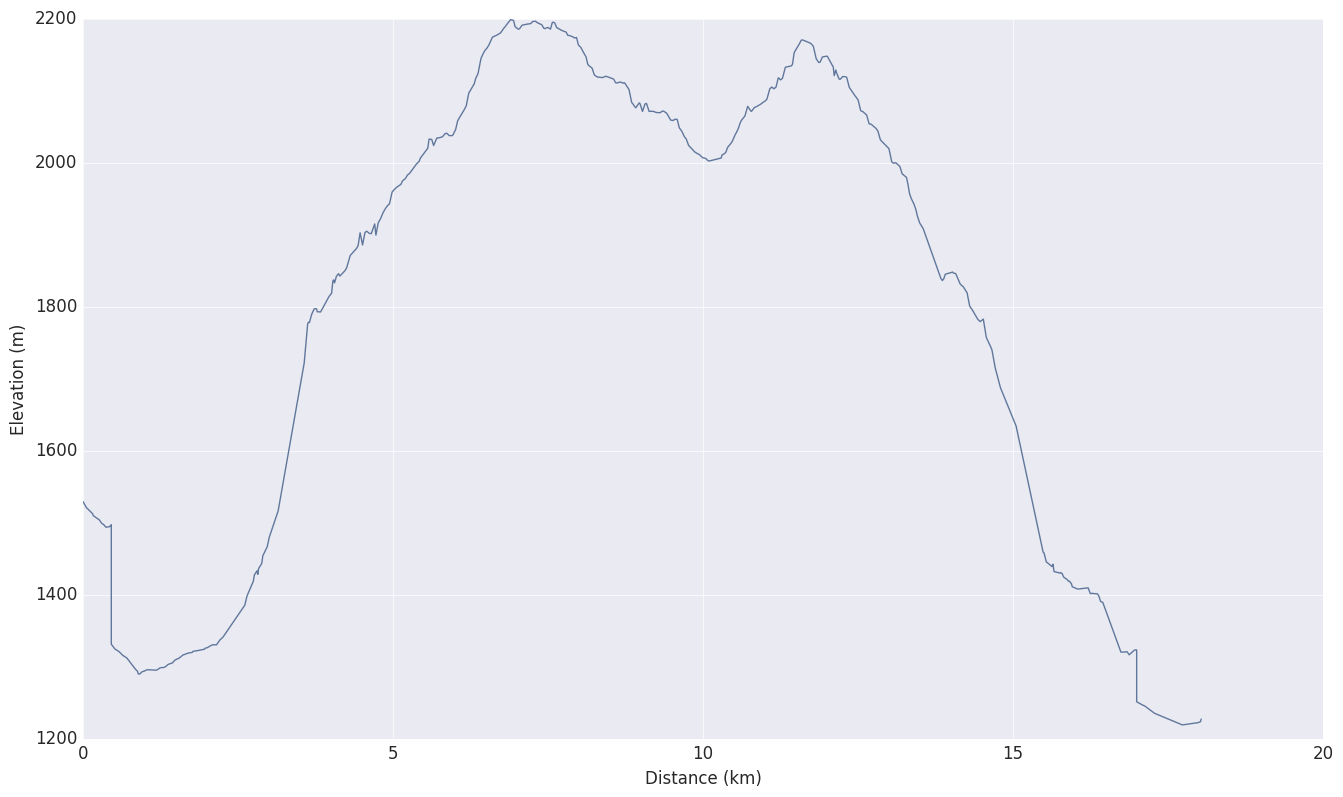

In [34]:
plot_day(8)

As we were approaching the end of the trip, we were more and more customizing the trip depending on our needs and physical conditions.

We really wanted to go have a look at the Lac Blanc the day after, but it wasn't a realistic goal unfortunately. Plus we learned that the weather would be quite unpleasant (rain), which made us consider stopping in Argentiere and skip the Lac Blanc.

The elevation graph shows a few vertical lines, due to GPS signal loss.

## Day 9: Argentiere - Chamonix

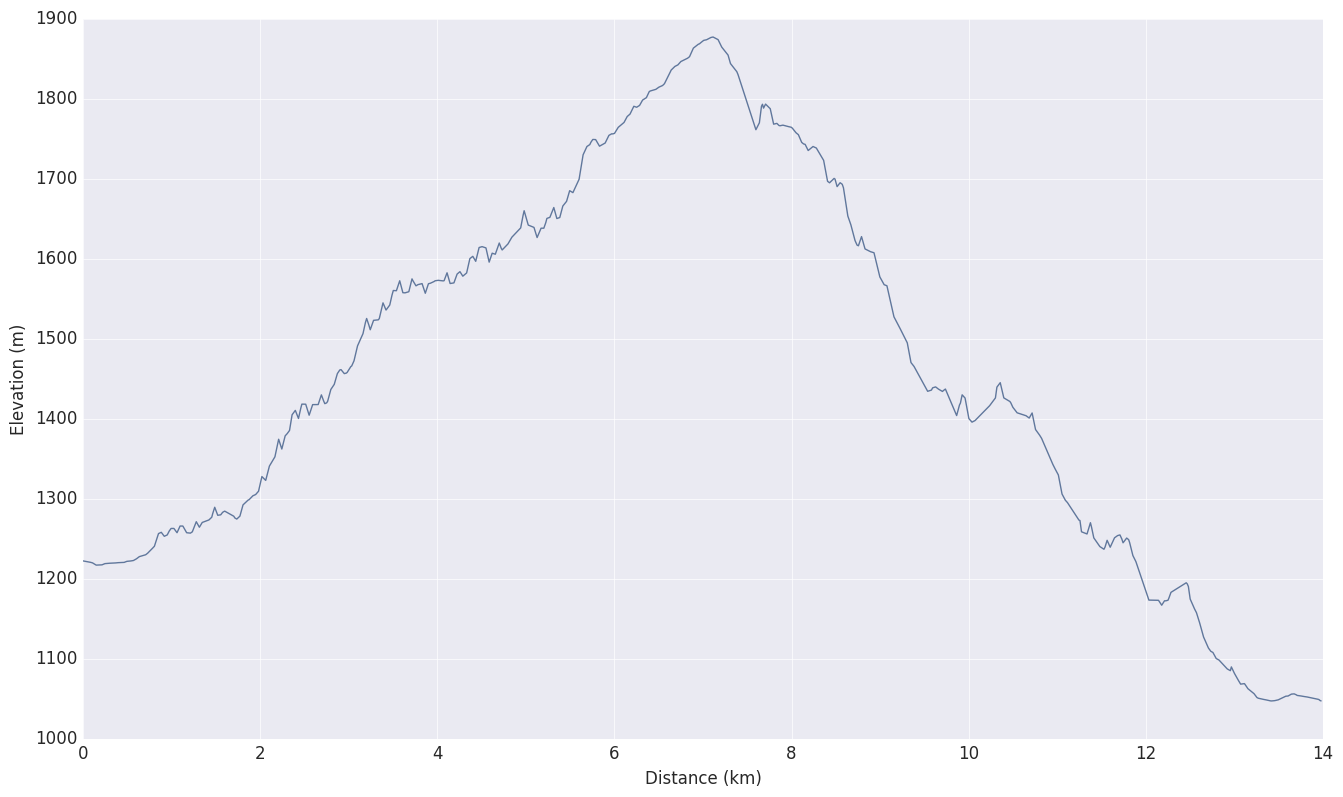

In [35]:
plot_day(9)

Last day of the trip. We decided to finish in Chamonix instead of Les Houches. I have to say it's not the complete loop, but we had time constraints to respect (9 days) and chosed the saner option!

## All In

In [36]:
qgrid.show_grid(df)

In [39]:
plot_all_tracks()

Its quite interesting to finally put everything together.

We can definitely notice the little gap between Chamonix and Les Houches.

Apart from that, there it is, out custom Tour du Mont-Blanc trail!

## Final words

Again, Jupyter notebooks came handy. Combining the narration of the trip with statistics for each day is very easy to do with a notebook.

I hope this will help some trekkers going for the Tour du Mont Blanc. It's a great experience, highly recommended!

The approach used in this notebook can also be adapted to other trips or hikes of course.

Happy trekking and coding!